In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


import glob
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from neuroformer.utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from neuroformer.visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done

from attention.LRN_attention import *

In [2]:
from neuroformer.prepare_data import load_LRN

df, stimulus = load_LRN()

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)

In [5]:
# load config files

import yaml

base_path = "./models/tensorboard/LRN/att_exp/2_window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)

In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
w_mult = 3
frame_window = dconf.frame_window
window = dconf.window
window_prev = dconf.window_prev
dt = dconf.dt
dt_frames = dconf.dt_frames
# p_window = window / (window + window_prev)
# intervals = np.load(os.path.join(base_path, "intervals.npy"))
intervals = None


from SpikeVidUtils import make_intervals

df['real_interval'] = make_intervals(df, dt)
df['Interval'] = make_intervals(df, window)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [7]:
int_trials = df.groupby(['Interval', 'Trial']).size()
print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])model_path
# var_group = 'Interval_2'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()

9.68422611538335


In [8]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_embd = mconf.n_embd
frame_feats = torch.tensor(stimulus, dtype=torch.float32).transpose(1, 0)
frame_block_size = mconf.frame_block_size  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = mconf.n_embd_frames

prev_id_block_size = mconf.prev_id_block_size    # math.ceil(frame_block_size * (1 - p_window))
id_block_size = mconf.id_block_size           # math.ceil(frame_block_size * p_window)
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = dconf.frame_memory   # how many frames back does model see

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }

In [9]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]

In [10]:
from SpikeVidUtils import SpikeTimeVidData2
from neuroformer.utils import update_object

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=intervals)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window,
                                 dt_frames=dt_frames, intervals=intervals)

update_object(train_dataset, tconf)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')


Population Size:  1003
ID Population Size:  1003
DT Population Size:  198
Population Size:  1003
ID Population Size:  1003
DT Population Size:  198
train: 58888, test: 14725


In [11]:
# from utils import get_class_weights
# class_weights = get_class_weights(train_dataset, stoi, stoi_dt)


In [12]:
from model_neuroformer_LRN import GPT, GPTConfig
# initialize config class and model (holds hyperparameters)
   
conv_layer = False
model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        n_embd_frames=n_embd_frames, dataset=None,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

update_object(model_conf, mconf)

model = GPT(mconf)

04/24/2023 13:16:23 - INFO - model_neuroformer_LRN -   number of parameters: 1.971406e+07


In [13]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 300
batch_size = round((14))
shuffle = True

weighted = True if mconf.class_weights is not None else False
title =  f'window:{window}_prev:{window_prev}_smooth'
model_path = f"""./models/tensorboard/LRN/ignore_index/2_{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# model_path = "/data5/antonis/neuroformer/models/tensorboard/LRN/channel/window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:True_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:12_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(8, 8, 8)_8_256.pt"
# if os.path.exists(model_path):
#     print(f"Loading model from {model_path}")
#     model.load_state_dict(torch.load(model_path))
# else:
#     print(f"Model not found at {model_path}")
#     raise FileNotFoundError

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

# trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()

In [14]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=shuffle, num_workers=4, pin_memory=True)
iterable = iter(loader)

In [15]:
x, y = next(iterable)

In [32]:
"""

RUN SIMULATION

"""

from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

model_weights = glob.glob(os.path.join(base_path, '**/**.pt'), recursive=True)
model_weights = sorted(model_weights, key=os.path.getmtime, reverse=True)
assert len(model_weights) > 0, "No model weights found"


if model_path in model_weights:
    load_weights = model_path
else:
    load_weights = model_weights[0]

print(f'Loading weights from {os.path.basename(model_weights[0])}')

# load_weights = "./models/tensorboard/LRN/att_exp/2_window:0.5_prev:19.5_smooth/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:False_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:64_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(8, 8, 8)_8_256.pt"

# load_weights = "./models/tensorboard/LRN/final/p_reduce_20_window:0.5_prev:19.5/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:False_window:0.5_f_window:20_df:0.1_blocksize:150_conv_False_shuffle:True_batch:58_sparse_(None_None)_blocksz1150_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_197_max0.1_(4, 4, 4)_1_256.pt"
model.load_state_dict(torch.load(load_weights, map_location=torch.device('cpu')))

trials = test_data['Trial'].unique()[:4]

Loading weights from _epoch_1000.pt


In [33]:
att_matrix = np.zeros((len(stoi.keys()), 1000))
neurons = sorted(list(set(df['ID'].unique())))

att_data = df[df['Trial'].isin([i for i in range(0, 500)])]
att_dataset = SpikeTimeVidData2(att_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=intervals)
loader = DataLoader(att_dataset, batch_size=3, shuffle=True, num_workers=1)
# model = model.to("cuda")

Population Size:  1003
ID Population Size:  1003
DT Population Size:  198


In [34]:
loader = DataLoader(att_dataset, batch_size=3, shuffle=True, num_workers=1)
iterable = iter(loader)

In [35]:
x, y = next(iterable)

In [36]:
_, _, _, = model(x, y)

attentions = get_atts(model)

In [37]:
LAYER_KEY = "neural_stimulus_block"

attentions['neural_state_block_0'].shape

agg_atts = cat_atts(attentions, LAYER_KEY)
print(agg_atts.shape)
agg_atts = stack_atts(attentions, LAYER_KEY)
print(agg_atts.shape)

torch.Size([24, 8, 150, 1000])
torch.Size([3, 8, 8, 150, 1000])


In [38]:
print(attentions.keys())
attentions['neural_stimulus_block_4'].shape

dict_keys(['neural_state_block_0', 'neural_state_block_1', 'neural_state_block_2', 'neural_state_block_3', 'neural_state_block_4', 'neural_state_block_5', 'neural_state_block_6', 'neural_state_block_7', 'neural_state_history_block_0', 'neural_state_history_block_1', 'neural_state_history_block_2', 'neural_state_history_block_3', 'neural_state_history_block_4', 'neural_state_history_block_5', 'neural_state_history_block_6', 'neural_state_history_block_7', 'neural_stimulus_block_0', 'neural_stimulus_block_1', 'neural_stimulus_block_2', 'neural_stimulus_block_3', 'neural_stimulus_block_4', 'neural_stimulus_block_5', 'neural_stimulus_block_6', 'neural_stimulus_block_7'])


torch.Size([3, 8, 150, 1000])

In [39]:
cat_atts(attentions, LAYER_KEY).shape

torch.Size([24, 8, 150, 1000])

In [40]:
attentions.keys()

dict_keys(['neural_state_block_0', 'neural_state_block_1', 'neural_state_block_2', 'neural_state_block_3', 'neural_state_block_4', 'neural_state_block_5', 'neural_state_block_6', 'neural_state_block_7', 'neural_state_history_block_0', 'neural_state_history_block_1', 'neural_state_history_block_2', 'neural_state_history_block_3', 'neural_state_history_block_4', 'neural_state_history_block_5', 'neural_state_history_block_6', 'neural_state_history_block_7', 'neural_stimulus_block_0', 'neural_stimulus_block_1', 'neural_stimulus_block_2', 'neural_stimulus_block_3', 'neural_stimulus_block_4', 'neural_stimulus_block_5', 'neural_stimulus_block_6', 'neural_stimulus_block_7'])

In [47]:
from visualize import set_plot_white
import logging

set_plot_white()

GRAD_COND = True
LAYER_KEY = "neural_stimulus_block"

neurons = []
att_scores = []
att_scores_grad = [] 

loader = DataLoader(att_dataset, batch_size=1, shuffle=True, num_workers=2)
iterable = iter(loader)

last_layer = "neural_stimulus_block_{n}".format(n=mconf.n_stimulus_layers-1)
n_neurons = 10
ncols = 5
nrows = n_neurons // ncols + 1

plt.figure(figsize=(40, (20) * (n_neurons // 20)))

model.eval()
model.to("cpu")
n_idx = 3
counter = 0

print(f"-- Running {n_neurons} steps of attention formulation --")
pbar = tqdm(total=n_neurons)
while counter < n_neurons:
    # print(f"Counter: {counter} / {n_neurons}")
    x, y = next(iterable)

    try:
        neuron_x = int(itos[int(x['id'].flatten()[n_idx])])
        neuron_y = int(itos[int(y['id'].flatten()[n_idx])])
        counter += 1
        pbar.update(1)
        # logging.info(f"Counter: {counter} / {n_neurons}")
        neurons.append({"x": neuron_x, "y": neuron_y})
    except:
        continue

    model.zero_grad()
    with torch.set_grad_enabled(GRAD_COND):
        _, _, _, = model(x, y)
    attentions = get_atts(model)
    
    att_scores.append(cat_atts(attentions, LAYER_KEY))

    # if GRAD_COND:
    gradients = get_grads(model)
    attentions = gradcam(attentions, gradients)
    att_scores_grad.append(cat_atts(attentions, LAYER_KEY))

    att_vis = torch.cat([attentions[k] for k in attentions.keys() if k.startswith(LAYER_KEY)])
    # att_vis = attentions[last_layer].mean(dim=1)[0][0]
    att_vis = cat_atts(attentions, LAYER_KEY).max(dim=1)[0]
    att_vis_mean = att_vis.min(dim=0)

-- Running 10 steps of attention formulation --


100%|██████████| 10/10 [00:03<00:00,  5.27it/s]

<Figure size 2880x0 with 0 Axes>

In [48]:
neuron_att_dict_state = collections.defaultdict(list)
neuron_att_dict_idx = collections.defaultdict(list)

print(f"-- now building matrix --")
pbar = tqdm(total=len(neurons))
for idx, row in enumerate(neurons):
    xid = row['x']
    attention = att_scores[idx]
    neuron_att_dict_state[str(xid)].append(attention)
    neuron_att_dict_idx[str(xid)].append(attention)

for key in neuron_att_dict_state.keys():
    neuron_att_dict_state[key] = torch.stack(neuron_att_dict_state[key])
for key in neuron_att_dict_idx.keys():
    neuron_att_dict_idx[key] = torch.stack(neuron_att_dict_idx[key])

# # save neuron_att_dict_state and idx as .mat files
# import scipy.io as sio

# save_path = ""
# sio.savemat(os.path.join(save_path, 'attentions/neuron_att_dict_state'), neuron_att_dict_state)
# sio.savemat(os.path.join(save_path, 'attentions/neuron_att_dict_idx.mat'), neuron_att_dict_idx)

-- now building matrix --


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


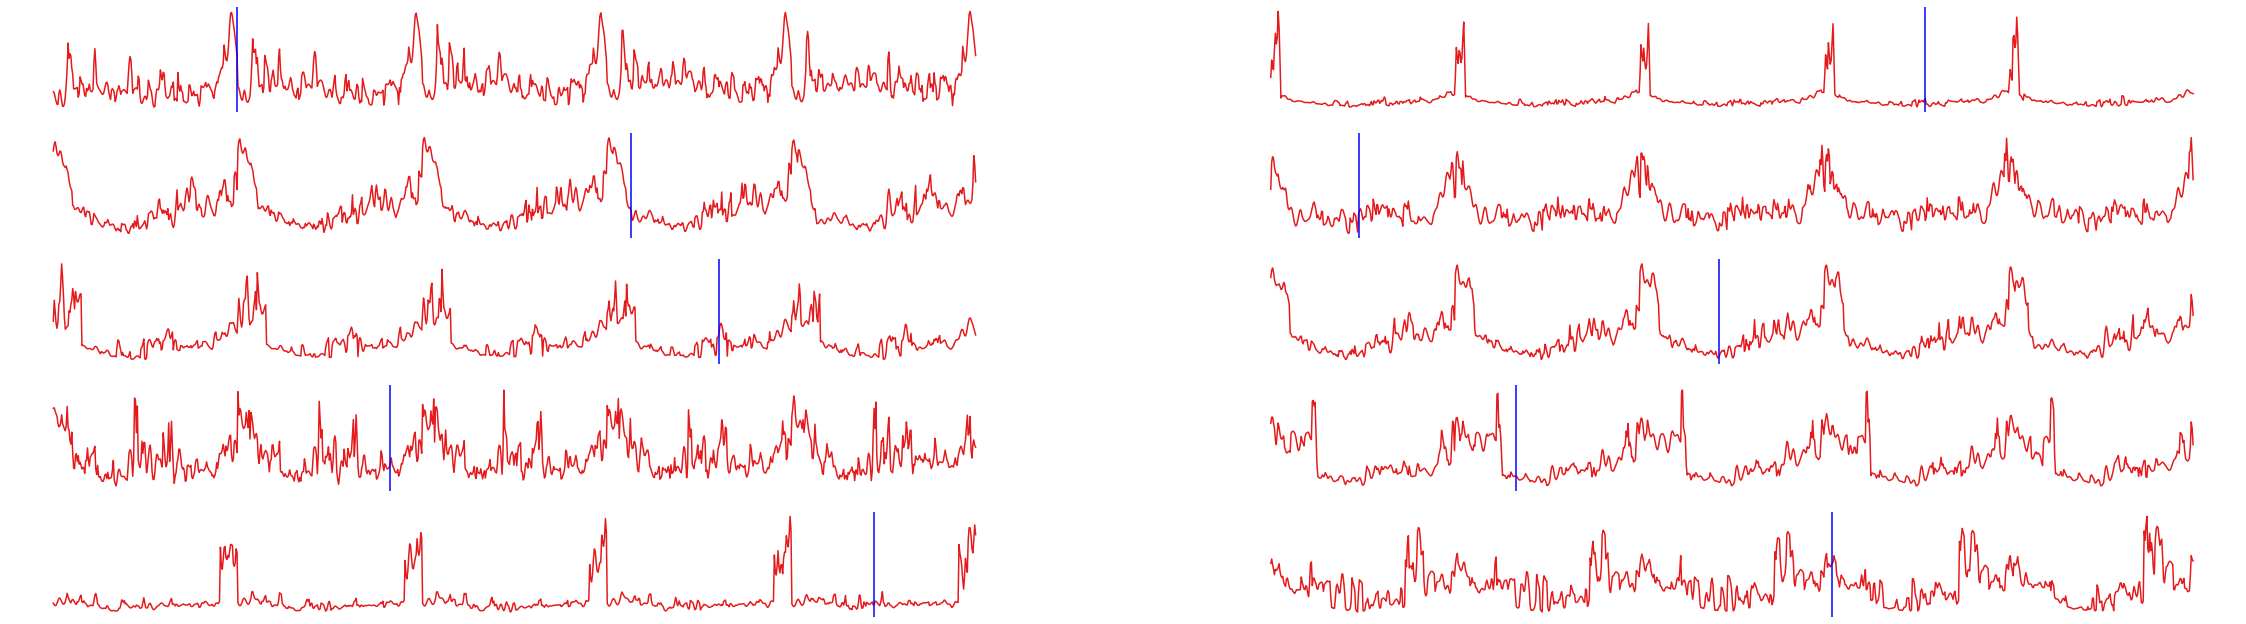

In [49]:
plt.figure(figsize=(40, 60))
n_plots = 50
ncols = 2
nrows = n_plots // ncols + 1

n_neurons = 10
for idx, neuron in enumerate(neuron_att_dict_state.keys()):
    av_attention_full = neuron_att_dict_state[neuron].max(-4)[0].min(-3)[0].mean(0).mean(0)
    av_attention_mean = av_attention_full.reshape(-1, 1000).mean(0)
    plt.subplot(nrows, ncols, idx+1)
    plt.plot(av_attention_mean)
    plt.axvline(int(neuron), color="blue")
    # plt.subplot(nrows, ncols, idx+1+ncols)
    # plt.plot(av_attention_full)
    
    # plt.title(f"{neurons}")
    plt.axis("off")
    if idx >= n_plots:
        break

In [50]:
GRAD_COND = True
LAYER_KEY = "neural_stimulus_block"

lw = 5
fs = 15

In [53]:
attentions["neural_stimulus_block_0"].shape

torch.Size([1, 8, 150, 1000])

: 

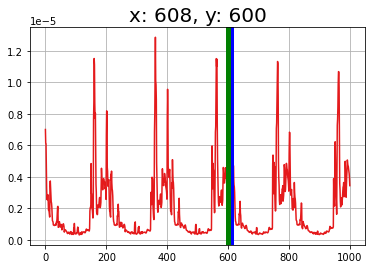

In [51]:
att_vis = torch.cat([attentions[k] for k in attentions.keys() if k.startswith(LAYER_KEY)])
att_vis = att_vis.max(0)[0].min(0)[0]

plt.figure()
plt.grid()
plt.title(f"x: {neuron_x}, y: {neuron_y}", fontsize=20)
plt.plot(att_vis[n_idx])
plt.axvline(x=neuron_x, color='b', label='x', linewidth=lw)
plt.axvline(x=neuron_y, color='g', label='y', linewidth=lw)

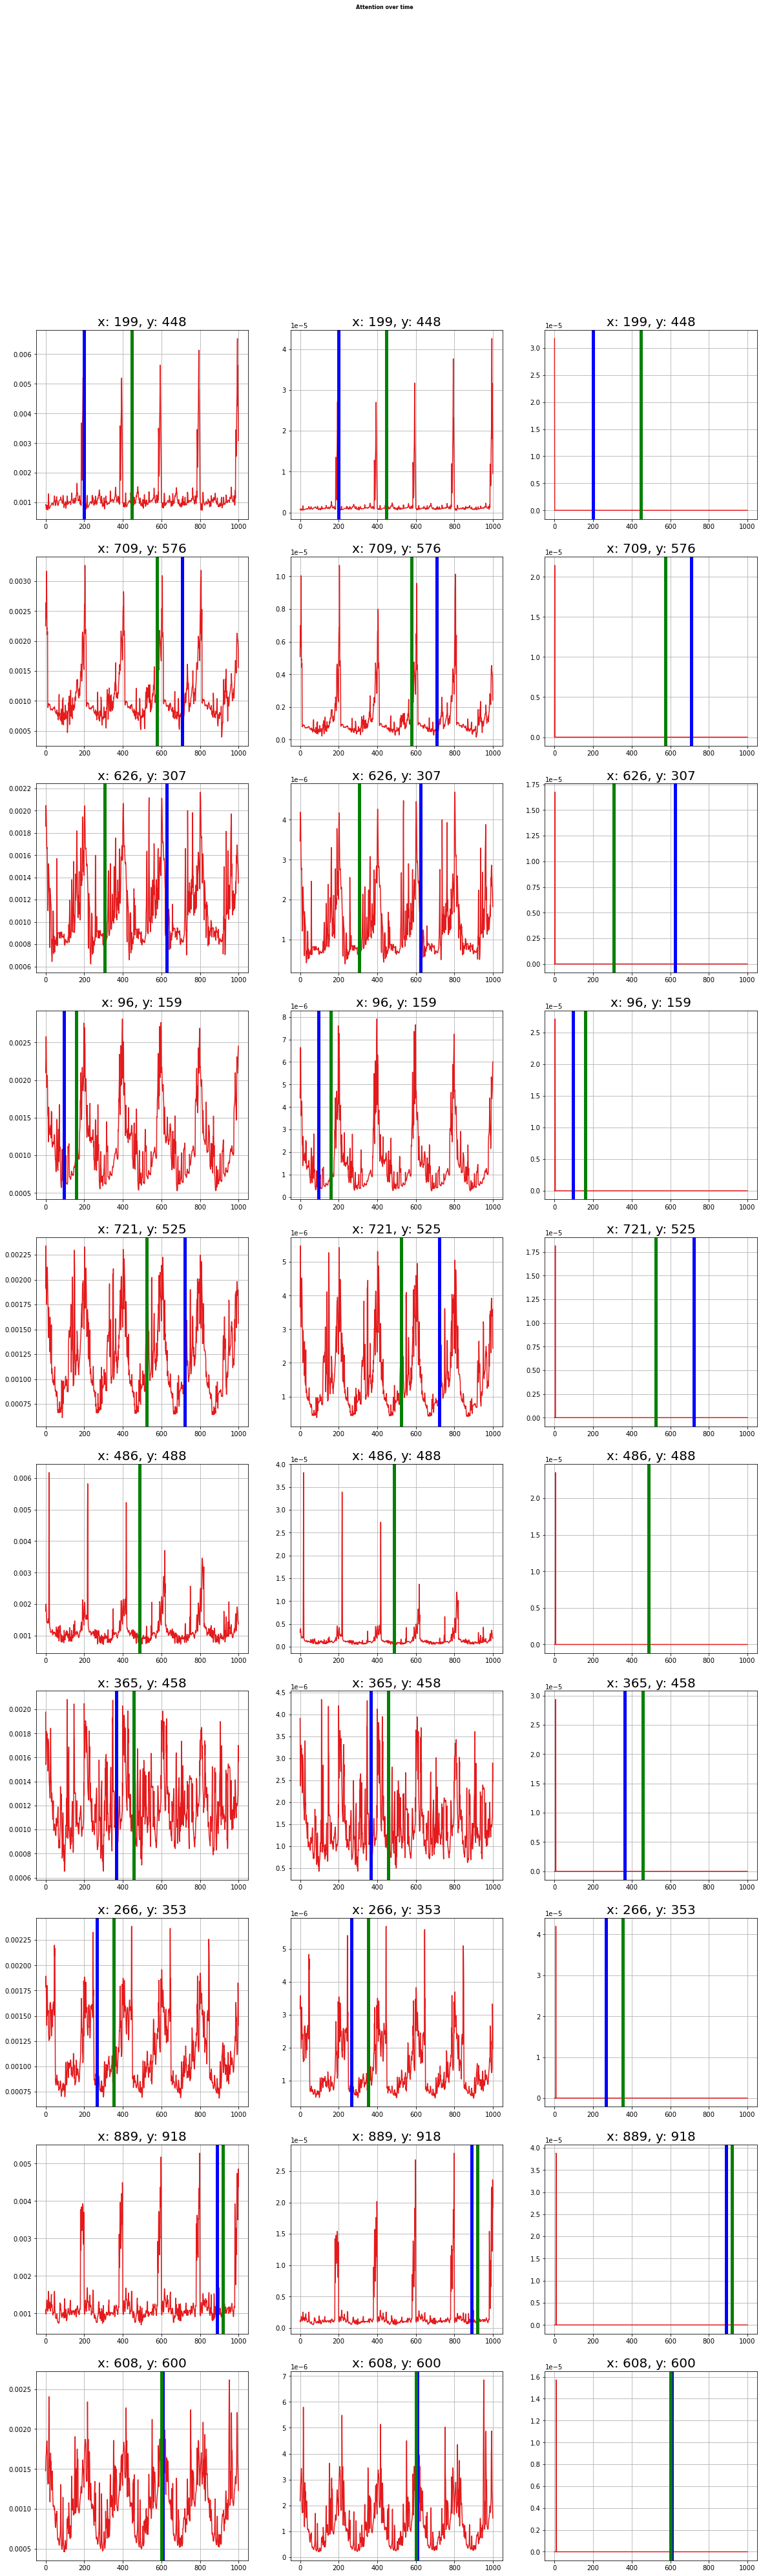

In [52]:
from neuroformer.attentionVis import rollout_attentions

rollout_atts = [rollout_attentions(att) for att in att_scores]
att_types = [att_scores, att_scores_grad, rollout_atts]

ncols = len(att_types)
nrows = len(neurons) + 1

plt.figure(figsize=(20, (70)))
title = "Attention over time"


for n_idx, row in enumerate(neurons):
    for n_att, attention in enumerate(att_types):
        neuron_x = row['x']
        neuron_y = row['y']

        # att_vis = torch.cat([attention[k] for k in attention.keys() if k.startswith(LAYER_KEY)])
        # att_vis = att_vis[-1].min(0)[0]
        attention = attention[n_idx]
        if len(attention.shape) == 4:
            att_vis = attention.max(0)[0].min(0)[0]
            # att_vis = attention[-1].min(0)[0]
        else:
            att_vis = attention

        plt.subplot(nrows, ncols, n_idx * ncols + n_att + 1)
        plt.grid()
        plt.title(f"x: {neuron_x}, y: {neuron_y}", fontsize=20)
        plt.plot(att_vis[n_idx])
        plt.axvline(x=neuron_x, color='b', label='x', linewidth=lw)
        plt.axvline(x=neuron_y, color='g', label='y', linewidth=lw)
plt.suptitle(title)

save_path = os.path.join(base_path,'attention', 'channels')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
n_files = glob.glob(os.path.join(save_path, '*/*.svg'))
plt.savefig(os.path.join(save_path, f"{title}_{len(n_files)}.png"))

In [ ]:
from neuroformer.attentionVis import rollout_attentions
from attention.LRN_attention import reshape_attentions

rollout_atts = [rollout_attentions(att) for att in att_scores]
att_types = [att_scores, att_scores_grad, rollout_atts]

ncols = len(att_types)
nrows = len(neurons) + 1

plt.figure(figsize=(20, (70)))
title = "Attention averaged over time"

for n_idx, row in enumerate(neurons):
    for n_att, attention in enumerate(att_types):
        neuron_x = row['x']
        neuron_y = row['y']

        # att_vis = torch.cat([attention[k] for k in attention.keys() if k.startswith(LAYER_KEY)])
        # att_vis = att_vis[-1].min(0)[0]
        attention = attention[n_idx]
        if len(attention.shape) == 4:
            att_vis = attention.max(0)[0].min(0)[0]
            # att_vis = attention[-1].min(0)[0]
        else:
            att_vis = attention
        
        att_vis = reshape_attentions(att_vis, stimulus)

        plt.subplot(nrows, ncols, n_idx * ncols + n_att + 1)
        plt.grid()
        plt.title(f"x: {neuron_x}, y: {neuron_y}", fontsize=20)
        plt.plot(att_vis[n_idx])
        plt.axvline(x=neuron_x, color='b', label='x', linewidth=lw)
        plt.axvline(x=neuron_y, color='g', label='y', linewidth=lw)

save_path = os.path.join(base_path,'attention', 'channels')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
n_files = glob.glob(os.path.join(save_path, '*/*.svg'))
plt.savefig(os.path.join(save_path, f"{title}_{len(n_files)}.svg"))

In [ ]:
len(attention)

In [ ]:
len(neurons)

In [ ]:
att_vis